In [10]:
#include necessary packages
using Distributions
using PyPlot


In [1531]:
#generate toy-data
#three clusters, one null cluster, two signals 

#n by n grid 
#k clusters of signals, the rest are all null   

#point = (xloc, yloc, p-value)
n = 500; 
k = 2; 

null_dist = Uniform(0,1);
dataSet = zeros(n,n);

#generate k centers randomly
center_vec = Tuple{Int,Int}[]
for(i in 1:k)
    center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n)));
    while(center in center_vec) center = (rand(DiscreteUniform(1,n)), rand(DiscreteUniform(1,n))); end
    push!(center_vec, center); 
end

#generate k Beta distributions randomly 
betas = Float64[];
#alpha = 1/beta so only need to store one parameter
for(i in 1:k)
    push!(betas, rand(Uniform(1,10)))
end


#given the center of a cluster 
#returns the points associated with the circle 
#uses the midpoint circle algorithm
function getCluster(center, n, radius)
    cluster = Tuple{Int,Int}[];
    for(rad in 1:radius)
        x0 = center[1]
        y0 = center[2];
        y = 0;
        x = rad; 
        err = 0; 
        while(x >= y)
            push!(cluster,(x0 + x, y0 + y));
            push!(cluster,(x0 + y, y0 + x));
            push!(cluster,(x0 - y, y0 + x));
            push!(cluster,(x0 - x, y0 + y));
            push!(cluster,(x0 - x, y0 - y));
            push!(cluster,(x0 - y, y0 -x));
            push!(cluster,(x0 + y, y0 - x));
            push!(cluster,(x0 + x, y0 - y));
            if(err <= 0)
                    y = y+1
                    err = err + 2*y + 1;
            end
            if(err > 0)
                x = x -1;
                err = err - (2*x + 1)
            end
        end
    end
    return cluster
end
    

#generate k clusters with randomly generated radius 
cluster_arr = Array{Tuple{Int,Int},1}[];
for(i in 1:k)
    #radius = round(rand(Exponential(20)));
    radius = 50
    push!(cluster_arr, getCluster(center_vec[i], n, radius))
end


#generate dataset
for(i in 1:n)
    for(j in 1:n)
        is_null = true;
        for(z in 1:k)
            cluster = cluster_arr[z];
            beta = betas[z];
            beta_dist = Beta(1/beta,beta);
            if((i,j) in cluster)
                is_null = false; 
                dataSet[i,j] = rand(beta_dist);
            end
        end
        if(is_null) dataSet[i,j] = rand(null_dist); end
    end
end

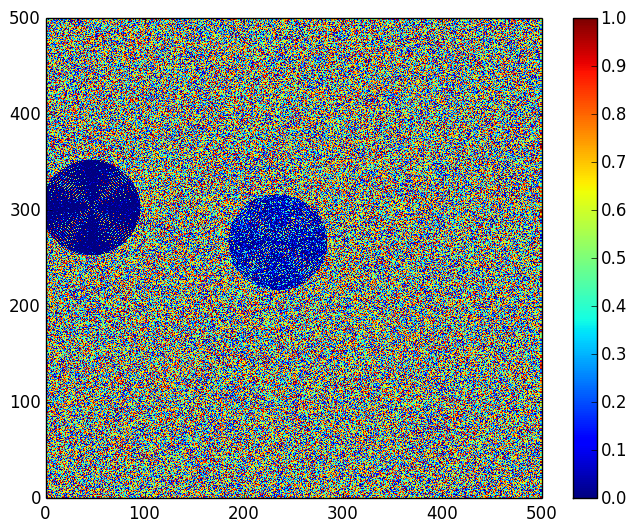

PyObject <matplotlib.colorbar.Colorbar instance at 0x3577454d0>

In [1532]:
pcolormesh(dataSet)
colorbar()


In [1044]:
#MCMC method of learning parameters of data 
#initial example of just learning one beta distribution 

#location and scale for levy distribution 
mu = 1; 
c = 0.5; 

prior_dist = TruncatedNormal(mu, sigma, 1, 10);
b = rand(prior_dist);
n = 500; 
data = rand(Beta(1/b,b),n)

println("True b: ", b)

#initial parameters 
b_init = 10; 
b_curr = b_init;
prop_width = 0.1; 
b_arr = Float64[]; 
for(i in 1:10000)
    #proposed jump is just randomly selected from around the current value
    b_prop = rand(Normal(b_curr, prop_width));
    if(b_prop < 1) continue; end;
    #compute the log-likelihood of this proposal and current distribution 
    #likelihood_current = 1; 
    #likelihood_prop = 1; 
    
    
    curr_dist = Beta(1/b_curr, b_curr);
    prop_dist = Beta(1/b_prop, b_prop); 
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data);
    
    #compute prior probability of current and proposed beta distribution 
    prior_current = pdf(prior_dist, b_curr);
    prior_prop = pdf(prior_dist, b_prop);

    p_curr = likelihood_current + log(prior_current);
    p_prop = likelihood_prop + log(prior_prop);
    
    p_accept = exp(p_prop - p_curr); 
    
    #flip a p-weighted coin to determine whether we accept or not
    if(rand() < p_accept)
        b_curr = b_prop;
    end
    push!(b_arr, b_curr); 
end


println("estimated b with MCMC: ", mean(b_arr))


True b: 3.620509338834046
estimated b with MCMC: 3.625297012177905


In [1539]:
#given proposal returns the step that metropolis chooses
function getMetropolisStep(prop, curr, prior_dist, curr_dist, prop_dist, data)
    n = length(data)
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data); 

    prior_current = log(pdf(prior_dist, curr));
    prior_prop = log(pdf(prior_dist, prop));

    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;

    p_accept = exp(p_prop-p_curr); 

    #flip a p-weighted coin to determine whether we accept the change
    if(rand() < p_accept)
        return prop; 
    end
    return curr; 
end


#labels_dist is array of distribution of the labels
function getMetropolisStepLabels(prop, curr, prior_dist, labels_dist, data, num_clusters)
    #compute likelihoods
    likelihood_current = 0; 
    likelihood_prop = 0; 
    for(i in 1:num_clusters)
        cluster_curr = data[curr.==i];
        cluster_prop = data[prop.==i];
        likelihood_current = likelihood_current + loglikelihood(labels_dist[i], cluster_curr);
        likelihood_prop = likelihood_prop + loglikelihood(labels_dist[i], cluster_prop);
    end
    
    #compute priors
    curr_val = [sum(curr.==i) for i in 1:num_clusters];
    prop_val = [sum(prop.==i) for i in 1:num_clusters];
    prior_current = log(pdf(prior_dist_labels, curr_val));
    prior_prop = log(pdf(prior_dist_labels, prop_val));
    
    #compute acceptance ratio
    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;
    p_accept = exp(p_prop-p_curr); 
    
    if(rand() < p_accept)
        return prop;
    end
    return curr; 
end

 
#t_0 - time we run the birth step process 
#lambda - birth rate
#pi_arr - mixture ratios, nonnegative and sum to 1
#b_arr - parameters for the beta distribution 
#likelihood function whihch 
#prior_k - prior distribution on number of components
function getBirthDeathStep(t_0, lambda, pi_arr, b_arr, likelihood, prior_k)
    k = length(pi_arr);
    delta_arr = zeros(k);   #death rate 
    for(j in 1:k)
       #calculate death rate of component j  
        pi_arr_death = copy(pi_arr);
        b_arr_death = copy(b_arr);
        deleteat!(pi_arr_deat, j);
        deletat!(b_arr_death, j);
        pi_arr_death = pi_arr_death./(1 - pi_arr[j]);    
        
        
      #calculate likelihood ratio of pi_arr_death vs
      ##to do
      
    end
    total_death_rate = sum(delta_arr); 
    
    #simulate time to nextjump from an exponential distribution with mean lambda + total_death _rate
    
    #simulate type of jump (death or birth) 
    #by a Bernoulli sample with p success (birth) = lambda/(lambda + total_death_rate)

    #calculate prior k ratio 
    priork_ratio =  prior_k(k-1)/(k*prior_k(k));
        
   
    #simulate the point at which birth takes place by simulating 
    Y_1 = rand(Gamma(1,1));
    Y_2 = rand(Gamma(k,1));
    pi = Y_1/(Y_1 + Y_2);
    #and then simulate beta from some other distribution  XX to do 
    
    
        
    end
end

LoadError: syntax: unexpected end

In [1530]:
#second example where we have two fixed clusters

#prior distribution for betas 
mu = 5; 
sigma = 2; 
prior_dist = TruncatedNormal(mu, sigma, 1, 20);

#data is drawn from two beta distributions
b_1 = rand(prior_dist);
b_2 = rand(prior_dist); 
#b_1 = 50; 
b_2 = 1;
num_clusters = 2; 

println("true beta_1: ", b_1, " true_beta_2: ", b_2)
n_1 = 1000; 
n_2 = 1000;

#distribution on members in each cluster 
prior_dist_labels = Multinomial(n_1+n_2,[0.5,0.5]);

data_1 = rand(Beta(1/b_1,b_1),n_1); 
data_2 = rand(Beta(1/b_2, b_2), n_2); 
data = [data_1; data_2];


#initially label the data randomly
labels = rand(DiscreteUniform(1,2), n_1 + n_2); 

b1_curr = 10; 
b2_curr = 5; 

b1_arr = Float64[];
b2_arr = Float64[]; 
nsamples = 2000; 

prop_width = 0.1; #proposed jump width for betas

#need markov chain to be reversible, it is right now :) 
for(i in 1:nsamples)
    #proposed jump for partitions, take k members and randomly flip the group assignments
    #either add it to the other group or keep it in the same group 
    k = rand(DiscreteUniform(1,5));
    k_indic = rand(DiscreteUniform(1,n_1 + n_2), k);
    proposed_labels = deepcopy(labels);
    proposed_labels[k_indic] = rand(DiscreteUniform(1,2),k);
  
    #distribution of the labels
    labels_dist = [Beta(1/b1_curr, b1_curr), Beta(1/b2_curr, b2_curr)];
    
    labels = getMetropolisStepLabels(proposed_labels, labels, prior_dist, labels_dist, data, num_clusters)
    
    #proposed jump for betas just randomly selected from around the current value
    b1_prop = rand(Normal(b1_curr, prop_width));
    b2_prop = rand(Normal(b2_curr, prop_width))
    
    #discard beta proposals that are outside the range of what we want
    while(b1_prop < 1)  b1_prop = rand(Normal(b1_curr, prop_width)); end;
    while(b2_prop < 1)  b2_prop = rand(Normal(b2_curr, prop_width)); end;
    
    b1_curr = getMetropolisStep(b1_prop, b1_curr, prior_dist, Beta(1/b1_curr, b1_curr), Beta(1/b1_prop, b1_prop), data[find(labels .== 1)]);
    b2_curr = getMetropolisStep(b2_prop, b2_curr, prior_dist, Beta(1/b2_curr, b2_curr), Beta(1/b2_prop, b2_prop),data[find(labels .== 2)]);
   
    push!(b1_arr,b1_curr);
    push!(b2_arr, b2_curr);
end
println("estimated b_1: ", mean(b1_arr[1000:end]), " estimated b_2: ", mean(b2_arr[1000:end]))


true beta_1: 4.009115132329621 true_beta_2: 1
estimated b_1: 2.0840580293741446 estimated b_2: 1.7498339391145006


In [1519]:
b2_arr

2000-element Array{Float64,1}:
 5.0    
 4.99335
 4.99335
 4.84986
 4.84986
 4.84986
 4.84986
 4.84986
 4.84986
 4.84986
 4.71975
 4.4931 
 4.34384
 ⋮      
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.58148
 1.59585
 1.59585

In [1527]:
#third example where we have a variable # of fixed clusters

#prior distribution for betas 
mu = 5; 
sigma = 2; 
prior_dist = TruncatedNormal(mu, sigma, 1, 20);

nsamples = 2000; 

#number of clusters 
num_clusters = rand(Binomial(10, 0.5));
 
#data is drawn from signals + 1 null cluster 
#b_arr = [rand(prior_dist, num_clusters); 1]
#num_clusters = num_clusters+1; 

b_arr = rand(prior_dist, num_clusters);

c_size = 500;
data = Float64[];
for(b in b_arr)
    if(b == 1) c_size = 500; end
    data = [data; rand(Beta(1/b,b), c_size)];
end

println("true beta: ", round(sort(b_arr),3));
println("true number of clusters: ", num_clusters)


#distribution on members in each cluster 
prior_dist_labels = Multinomial(length(data),num_clusters);

#initially label the data randomly
labels = rand(DiscreteUniform(1,num_clusters), length(data)); 

#initialize starting beta randomly
bcurr_arr = rand(prior_dist, num_clusters)


prop_width = 0.1; #proposed jump width for betas

#num_clusters-1 signal clusters + 1 null cluster
bs = zeros(nsamples, num_clusters)
labels_arr = zeros(nsamples, length(data));


#need markov chain to be reversible, it is right now :) 
for(i in 1:nsamples) 
    #distribution of the labels
    labels_dist = [Beta(1/b, b) for b in bcurr_arr];
    num = 10; 
    for(j in 1:num)
        #proposed jump for partitions, take k members and randomly flip the group assignments
        #either add it to the other group or keep it in the same group 
        k = rand(DiscreteUniform(1,2));
        k_indic = rand(DiscreteUniform(1,length(data)), k);
        proposed_labels = copy(labels);
        proposed_labels[k_indic] = rand(DiscreteUniform(1,num_clusters),k);
        labels_dist = [Beta(b,1/b) for b in bcurr_arr];
        labels = getMetropolisStepLabels(proposed_labels, labels, prior_dist_labels, labels_dist, data, num_clusters)
    end

    #proposed jump for betas just randomly selected from around the current value
    for(curr_label in 1:num_clusters)
        num = 10;
        for(j in 1:num)
            b_prop = rand(Normal(bcurr_arr[curr_label], prop_width));
            while(b_prop < 1)  b_prop = rand(Normal(bcurr_arr[curr_label], prop_width)); end;
            curr_dist = Beta(1/bcurr_arr[curr_label], bcurr_arr[curr_label]); 
            prop_dist = Beta(1/b_prop, b_prop); 
            cluster = data[find(labels .== curr_label)];
            bcurr_arr[curr_label]  = getMetropolisStep(b_prop, bcurr_arr[curr_label], prior_dist,curr_dist, prop_dist,cluster);
        end
    end     
    bs[i,:] = bcurr_arr; 
    labels_arr[i,:] = labels;
end

estimated_labels = round(mean(labels_arr,1)');
println("estimated beta: ", round(sort(vec(mean(bs,1))),3))



true beta: [3.435,4.653,5.512,6.299,7.562]
true number of clusters: 5
estimated beta: [5.233,5.244,5.244,5.255,5.255]


In [6]:
estimated_labels = round(mean(labels_arr,1)');
estimated_labels
plt[:hist](data)

LoadError: UndefVarError: labels_arr not defined

Let $x_1, \ldots, x_n$ be our data points and suppose our data is assumed to be independent observations from a mixture denstiy with $k$ (unknown) mixture components. 
\begin{equation*}
p(x | \pi, \phi, \eta) = \pi_1 f(x ; \phi_1, \eta) + \cdots + \pi_k f(x;\phi_k, \eta) 
\end{equation*}
$\pi_1 + \cdots + \pi_k = 1$ are mixture components $\phi_i$ are component specific parameters, and $\eta$ is a model specific parameter. For our specific model,  $\phi_j$ is the $\beta$ parameter of a beta distribution. That is, 
\begin{equation*}
f(x ; \phi_j, \eta) \sim Beta(1/\phi_j, \phi_j) 
\end{equation*}
and we assume that one of the clusters is a nulll cluster and the others are signal clusters. Null cluster has a higher mixing proportion. 

In [841]:
##matthew stephenson Bayesian analysis of mixtures 2000  

#given proposal stepr returns step metropolis chooses
function getMetropolisStepLabels(proposed_labels, current_labels, labels_prior, b_dist, data, num_clusters)    
    #compute likelihoods
    likelihood_current = 0; 
    likelihood_prop = 0; 
    for(i in 1:num_clusters)
        cluster_curr = data[current_labels.==i];
        cluster_prop = data[proposed_labels.==i];
        likelihood_current = likelihood_current + loglikelihood(b_dist[i], cluster_curr);
        likelihood_prop = likelihood_prop + loglikelihood(b_dist[i], cluster_prop);
    end

    #compute priors ##TO DO INCORPORTE LOCATION INFORMATION
    prior_current = logpdf(labels_prior, current_labels);
    prior_prop = logpdf(labels_prior, proposed_labels);
    
    #compute acceptance ratio
    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;
    p_accept = exp(p_prop-p_curr)[1]; 
    
    if(rand() < p_accept)
        return proposed_labels;
    end
    return current_labels; 
end

#given proposal returns the step that metropolis chooses
function getMetropolisStep(prop, curr, prior_dist, curr_dist, prop_dist, data)
    n = length(data)
    likelihood_current = loglikelihood(curr_dist, data);
    likelihood_prop = loglikelihood(prop_dist, data); 

    prior_current = log(pdf(prior_dist, curr));
    prior_prop = log(pdf(prior_dist, prop));

    p_curr = likelihood_current+prior_current;
    p_prop = likelihood_prop+prior_prop;

    p_accept = exp(p_prop-p_curr); 

    #flip a p-weighted coin to determine whether we accept the change
    if(rand() < p_accept)
        return prop; 
    end
    return curr; 
end



getMetropolisStepLabels (generic function with 1 method)

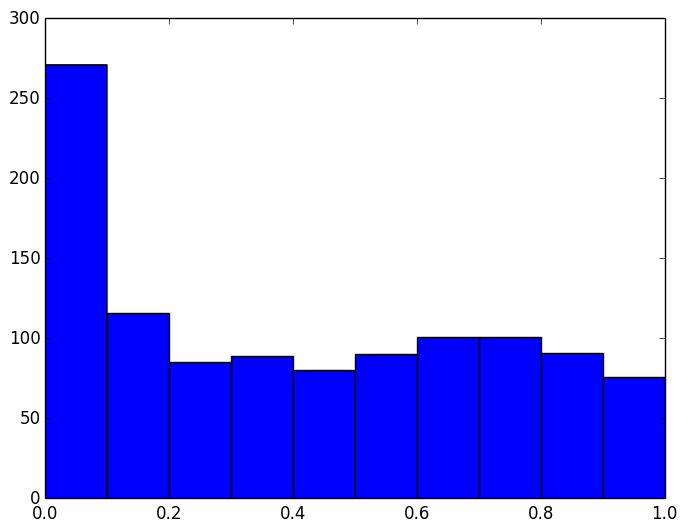

True Beta:1,100


In [1015]:
#generate data from mixture of 3 beta distributions
#true_model = MixtureModel(Beta[Beta(1,1), Beta(0.1,10)], [0.9, 0.1]);
#data = rand(true_model,500);
data = [rand(Beta(1,1), 900), rand(Beta(0.01,100),100),  rand(Beta(0.1,10),100)];
plt[:hist](data)
println("True Beta:", 1, ",", 100)

In [1057]:
#### STEPHENSON ALGORITHM WITHOUT PRIORS ON HYPERPARAMETERS

#prior distributions on parameters

#prior distribution on beta
mu = 5; 
sigma = 2; 
Beta_priordist = TruncatedNormal(mu, sigma, 1, 20);

#prior distribution on number of clusters
Clusters_priordist = Truncated(Poisson(1), 1, 100)

#initial number of clusters
num_clusters = 10; #number of clusters

#prior distribution on labels 
labels_prior = DiscreteUniform(1,num_clusters);

#prior distribution on mixing proportions
#Dirichlet with heavier weight on first component
null_prop = 0.9; 
#this is the prior on the mixing components 
mixing_prior = Dirichlet([null_prop; (1-null_prop)*ones(num_clusters-1)]);


#initialize rest of parameters
labels = rand(DiscreteUniform(1,num_clusters), length(data)); #labels of data 
mixture = rand(mixing_prior) #mixture proportions
bcurr_arr = rand(Beta_priordist, num_clusters); #beta distribution parameters

#sample number of clusters, mixture, and current bs by runnning birth death proccess

#num_clusters, mixture, bcurr_arr = getBirthDeathStep(num_clusters, mixture, bcurr_arr, data, likelihood,Clusters_priordist)
lambda = 10;  #birth rate 

################################################
#### start birth death proccess to sample num_clusters, mixture proportions and current b
############################################
t_0 = 1; #total time we run the birth-death chain
birth_rate = lambda; 
curr_time = 0; 
num_clusters = length(bcurr_arr)

## does SUPER WELL if we start with the true parameters 
#bcurr_arr = [1.0, 100.0];
#mixture = [0.9, 0.1];

while(curr_time < t_0)
    delta_arr = zeros(num_clusters);   #death rate 

    #calculate loglikelihood of current mixture model 
    curr_dist =  MixtureModel(map(b->Beta(1/b,b), bcurr_arr), mixture);
    l_y = loglikelihood(curr_dist, data); 
    c_y = loglikelihood(Clusters_priordist, [num_clusters]);

    #calculate death rate of component j  
    if(num_clusters > 1)
        for(j in 1:num_clusters)
            #post-death vector 
            pi_arr_death = copy(mixture);
            b_arr_death = copy(bcurr_arr);
            deleteat!(pi_arr_death, j);
            deleteat!(b_arr_death, j);
            pi_arr_death = pi_arr_death./(1 - mixture[j]);    

            #note that this ignores labelling due to the exchangability assumption 
            #is this a problem? 

            #distribution of data after death 
            death_dist = MixtureModel(map(b->Beta(1/b,b), b_arr_death), pi_arr_death);
            l_dy = loglikelihood(death_dist, data)
            c_yd = loglikelihood(Clusters_priordist, [num_clusters-1]);

            #calculate death rate 
            delta_arr[j] = log(lambda) + (l_dy - l_y) + (c_yd - log(num_clusters) - c_y); 
        end
        death_rate = sum(exp(delta_arr)); 
    else
        delta_arr = [0];
        death_rate = 0; 
    end

    #simulate time to next birth/death from an exponential distribution 
    #with mean: birth_rate + death_rate
    t = 1/rand(Exponential(birth_rate + exp(death_rate)));
    curr_time = curr_time + t; 
    if(curr_time < t_0) #then we have a birth or a death 
        #flip a weighted coin to determine birth or death 
        is_birth = rand(Bernoulli(birth_rate/(birth_rate + death_rate)));
        #println(is_birth)
        if(is_birth == 1)#we have a birth 
            #simulate the point at which birth takes place by the following (see page 48 stephens) 
            Y_1 = rand(Gamma(1,1));
            Y_2 = rand(Gamma(num_clusters,1));
            p = Y_1/(Y_1 + Y_2);

            #simulate the beta parameter from the prior  
            b = rand(Beta_priordist)
            
            #update parameter vectors
            push!(bcurr_arr, b)
            mixture = mixture.*(1 - p);
            push!(mixture, p);
            num_clusters = num_clusters + 1; 
        else #we have a death 
            #select a component to die by sampling from a 
            #categorical distribution with vector delta_arr/death_rate
            sure_deaths = find(delta_arr .> 50);
           # println(delta_arr)
            if(length(sure_deaths) > 0) #for computational issue
                #println("die!")
                death_j = sure_deaths[1];
            else
                death_j = rand(Categorical(vec(exp(delta_arr)./death_rate)));
            end
            m_death = mixture[death_j];

            #update parameter vectors
            deleteat!(mixture, death_j);
            deleteat!(bcurr_arr, death_j);
            mixture = mixture./(1 - m_death);  
            num_clusters = num_clusters - 1; 
        end
    end
end

println(mixture, bcurr_arr)



[0.9632473109893458,0.0033483694863969413,0.03340431952429155][1.9900530811132708,9.547863117695009,6.3153956020495015]


In [1058]:
################################################
####
#### metropolis hastings to sample label from label distribution conditional on mixture, bcurr_arr and data 
#### this step is only done when there is more than one label 
####
############################################
#prior on labels 
## TO DO MAKE THIS INCORPORATE LOCATION INFORMATION RIGHT NOW IT DOES NOT 
labels_prior = DiscreteUniform(1,num_clusters);

#randomly assign labels to those points
#which got their cluster removed
num_removed =  sum(labels.>num_clusters)
labels[labels.>num_clusters] = rand(labels_prior, num_removed);
    
#now do metropolis hastings to sample from posterior using this as initial point
for(i in 1:10000)
    proposed_labels = copy(labels); 
    index = rand(DiscreteUniform(1,length(data)), 1);
    #randomly flip 1 member 
    proposed_labels = copy(labels);
    proposed_labels[index] = rand(DiscreteUniform(1,num_clusters),1);
    b_dist = [Beta(1/b,b) for b in bcurr_arr];
    #accept or reject according to metropolis rule
    labels = getMetropolisStepLabels(proposed_labels, labels, labels_prior, b_dist, data, num_clusters);
end



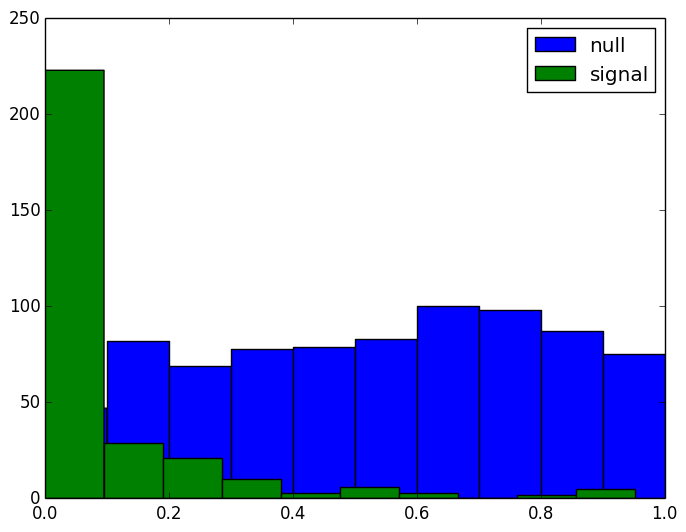

PyObject <matplotlib.legend.Legend object at 0x322989850>

In [1059]:
plt[:hist](data[labels.==1], label = "null") #data associated with null cluster
plt[:hist](data[labels.!= 1], label = "signal") #data associated with signals 
legend()

In [1062]:
################################################
####
#### metropolis hastings to sample mixture proportions and beta 
####
############################################
#null_prop = 0.9; 
#this is the prior on the mixing components 
#mixing_prior = Dirichlet([null_prop; (1-null_prop)*ones(num_clusters-1)]);

#first sample mixture proportions
## TO DO 


#then sample from beta distribution  
for(curr_label in 1:num_clusters)
    for(i in 1:1000)
        prop_width = 0.5
        #proposed betas are random step away from each beta
        b_prop = rand(Normal(bcurr_arr[curr_label], prop_width));
        while(b_prop < 1)  b_prop = rand(Normal(bcurr_arr[curr_label], prop_width)); end;
        curr_dist = Beta(1/bcurr_arr[curr_label], bcurr_arr[curr_label]); 
        prop_dist = Beta(1/b_prop, b_prop); 
        cluster = data[find(labels .== curr_label)];
        bcurr_arr[curr_label]  = getMetropolisStep(b_prop, bcurr_arr[curr_label],Beta_priordist,curr_dist, prop_dist,cluster);
    end
end     
bcurr_arr




3-element Array{Float64,1}:
  1.00417
 19.9125 
  4.54279